# IMAGE RECONSTRUCTION VIA PCA, PPCA AND VARIATIONAL AUTOENCODER

## LOADING THE DATASET

In [4]:
from keras.datasets import mnist
import numpy as np

(trainImages, _), (testImages, _) = mnist.load_data()

trainImages, testImages = trainImages / 255.0, testImages / 255.0

#print("Training dimensions:", trainImages.shape)
#print("Test dimensions:", testImages.shape)

flattenedTrainImages = trainImages.reshape((trainImages.shape[0], -1))
flattenedTestImages = testImages.reshape((testImages.shape[0], -1))

print("Flattened training dimensions:", flattenedTrainImages.shape)
print("Flattened test dimensions:", flattenedTestImages.shape)

np.random.seed(42)      #To ensure that same images are used across pca and ppca. Change seed value for different images
selectedImages = np.random.choice(len(testImages), size = 5, replace=False)

Flattened training dimensions: (60000, 784)
Flattened test dimensions: (10000, 784)


## PCA IMPLEMENTATION

MSE for latent dimension 2 is: 0.05566949404069115


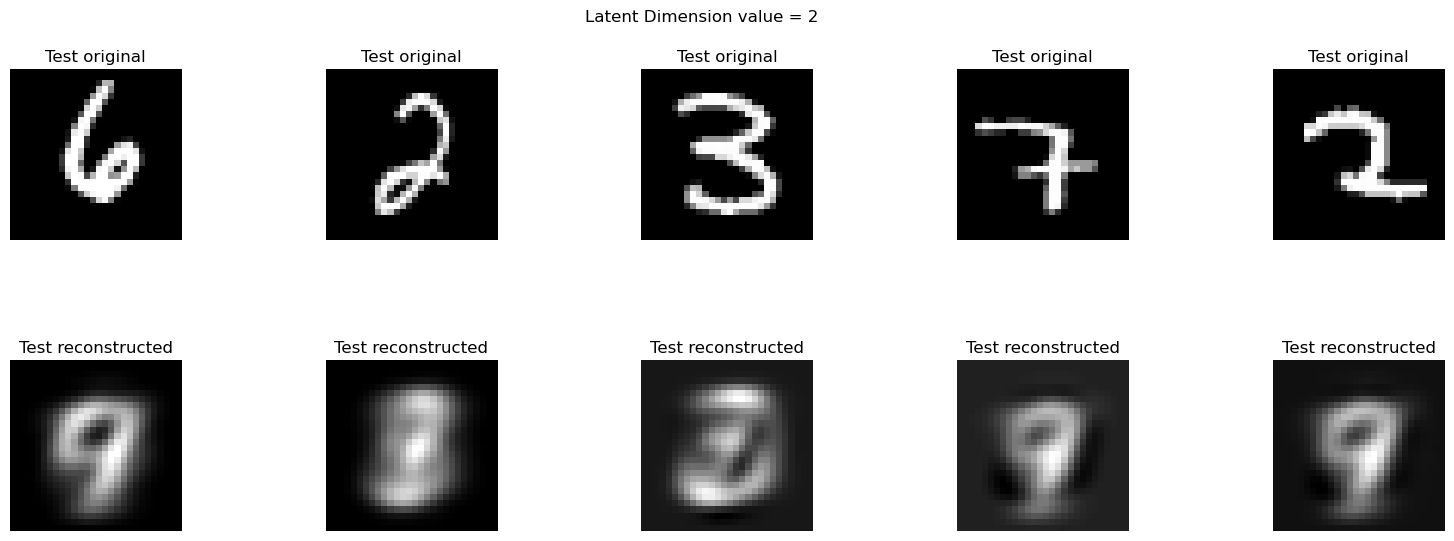

MSE for latent dimension 4 is: 0.04790347744044906


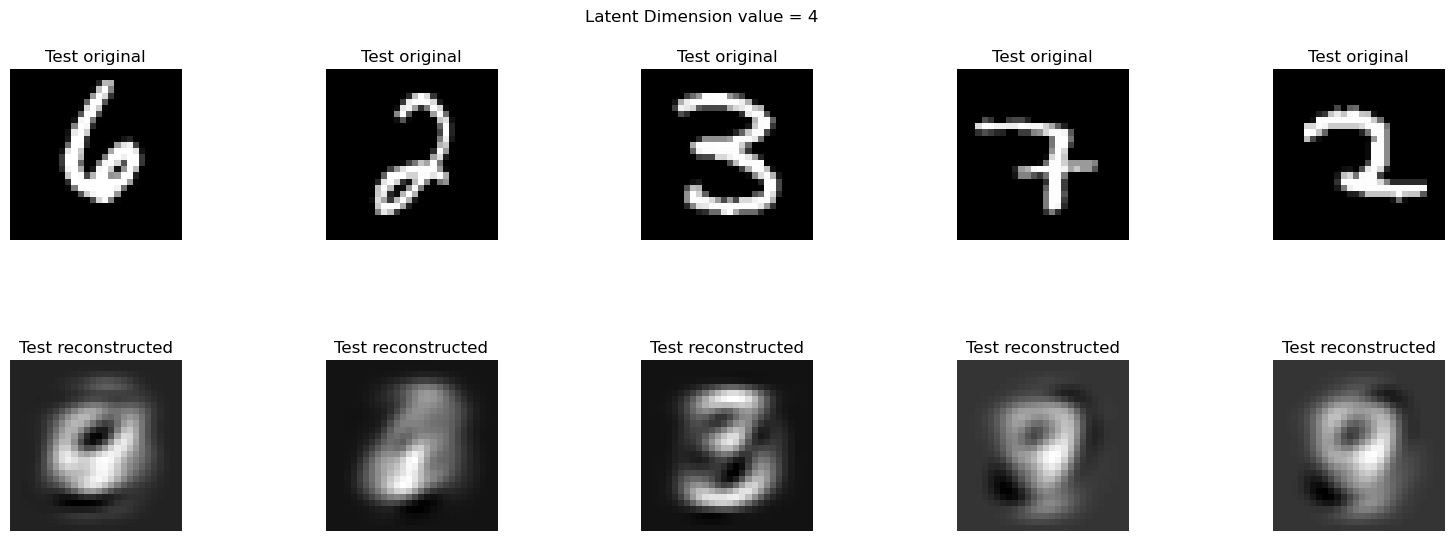

MSE for latent dimension 8 is: 0.03744094023409218


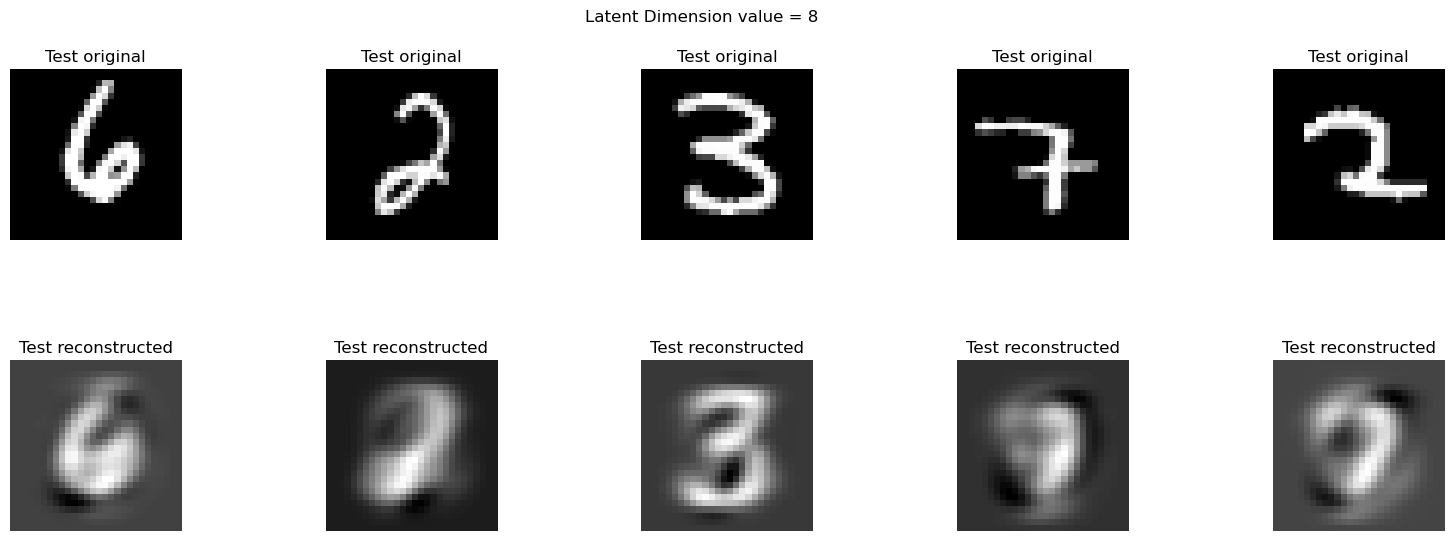

MSE for latent dimension 16 is: 0.026860424628445692


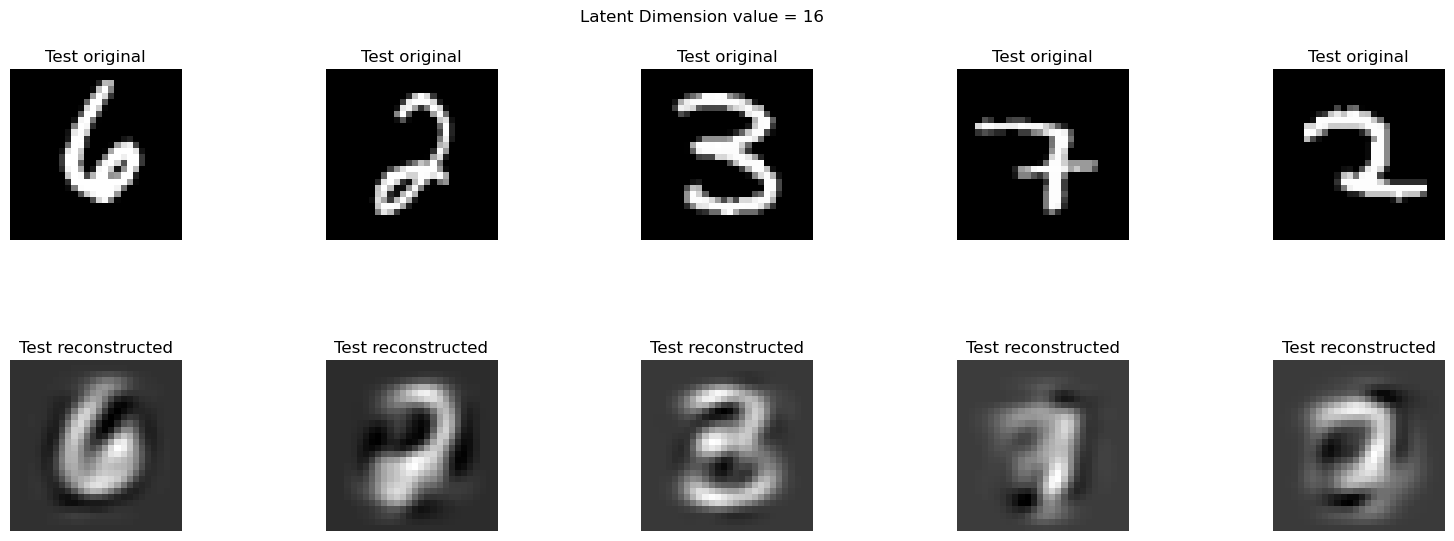

MSE for latent dimension 32 is: 0.016827672434550224


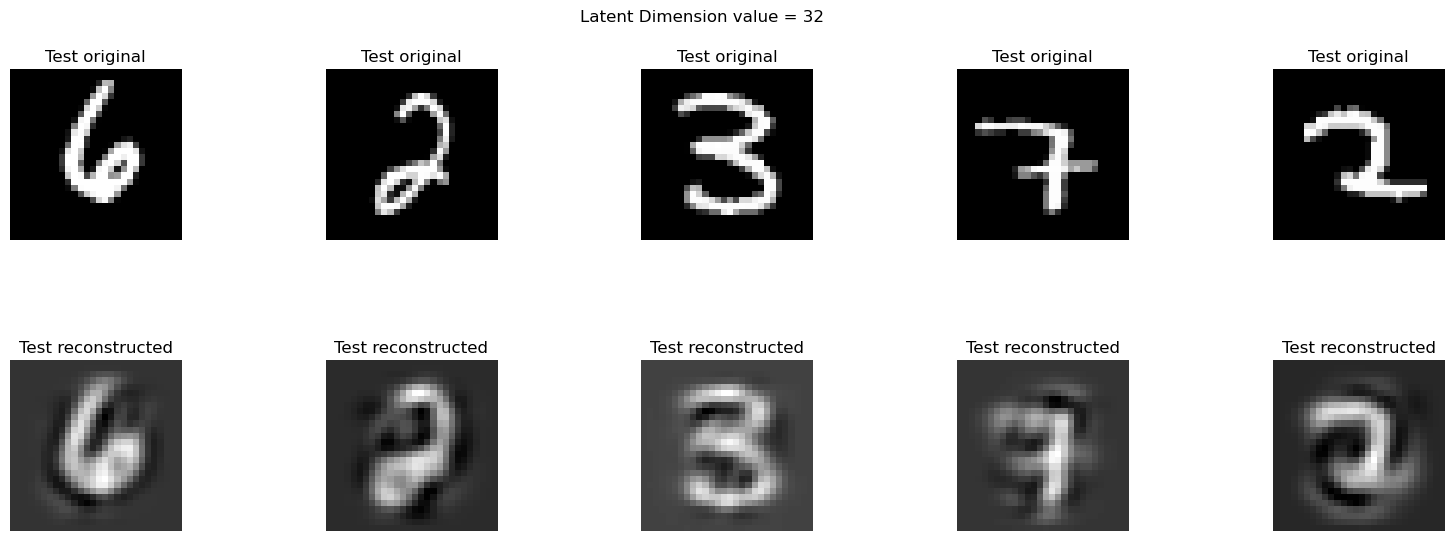

MSE for latent dimension 64 is: 0.009048210488846572


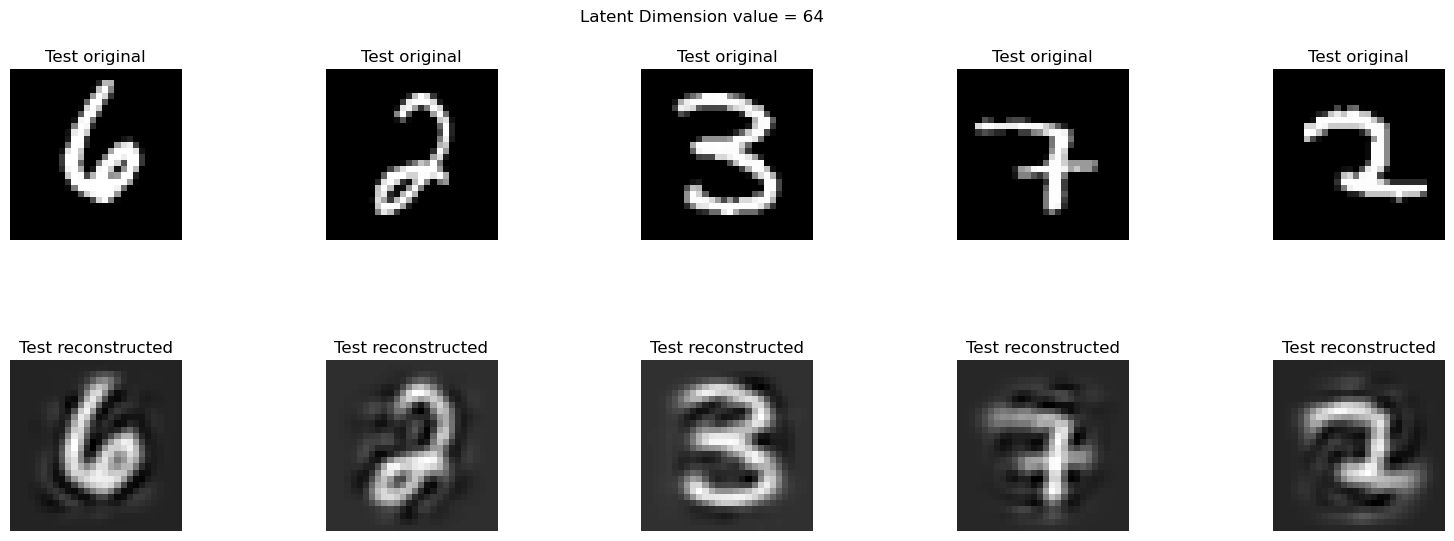

In [11]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

latentDimensions = [2, 4, 8, 16, 32, 64] 

def pcaFn(latentDimensionValue, flattenedTestImages):
    pca = PCA(n_components=latentDimensionValue)
    pca.fit(flattenedTrainImages)

    transformedImages = pca.inverse_transform(pca.transform(flattenedTestImages))
    transformedImages = transformedImages.reshape((-1, 28 * 28))    #Converting into 2d array

    return transformedImages

def pcaMSE(originalImages, reconstructedImages):
    return np.mean((originalImages - reconstructedImages)**2)

mse_values_list = []

for latentDimensionValue in latentDimensions:

    reconstructedImages = pcaFn(latentDimensionValue, flattenedTestImages)
    mseVal = pcaMSE(flattenedTestImages,reconstructedImages)
    mse_values_list.append(mseVal)
    
    print("MSE for latent dimension {} is: {}".format(latentDimensionValue,mseVal))

    plt.figure(figsize=(20,6))
    plt.suptitle(f"Latent Dimension value = {latentDimensionValue}")
 
    for i, idx in enumerate(selectedImages):
        plt.subplot(2, 5, i + 1)
        plt.imshow(testImages[idx], cmap='gray')
        plt.title(f"Test original")
        plt.axis('off') #Removes x and y axis labels

        plt.subplot(2, 5, i + 6)
        plt.imshow(reconstructedImages[idx].reshape(28,28), cmap='gray')    #reshaping the 1d array back to 2d for accessing
        plt.title(f"Test reconstructed")
        plt.axis('off')

    plt.subplots_adjust(hspace=0.7, wspace=0.1)
    plt.show()
    
mse_values_array = np.array(mse_values_list)


## PROBABILISTIC PCA IMPLEMENTATION

MSE val for latent dimension 2 is 0.10603286571981226


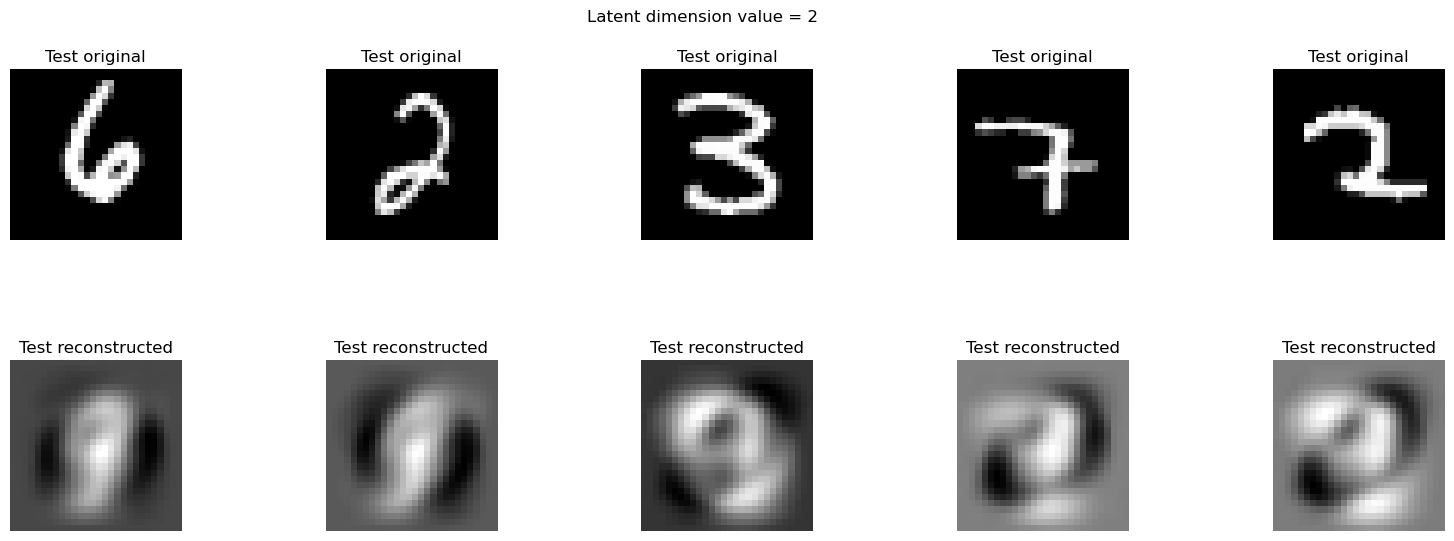

MSE val for latent dimension 4 is 0.12826227946705968


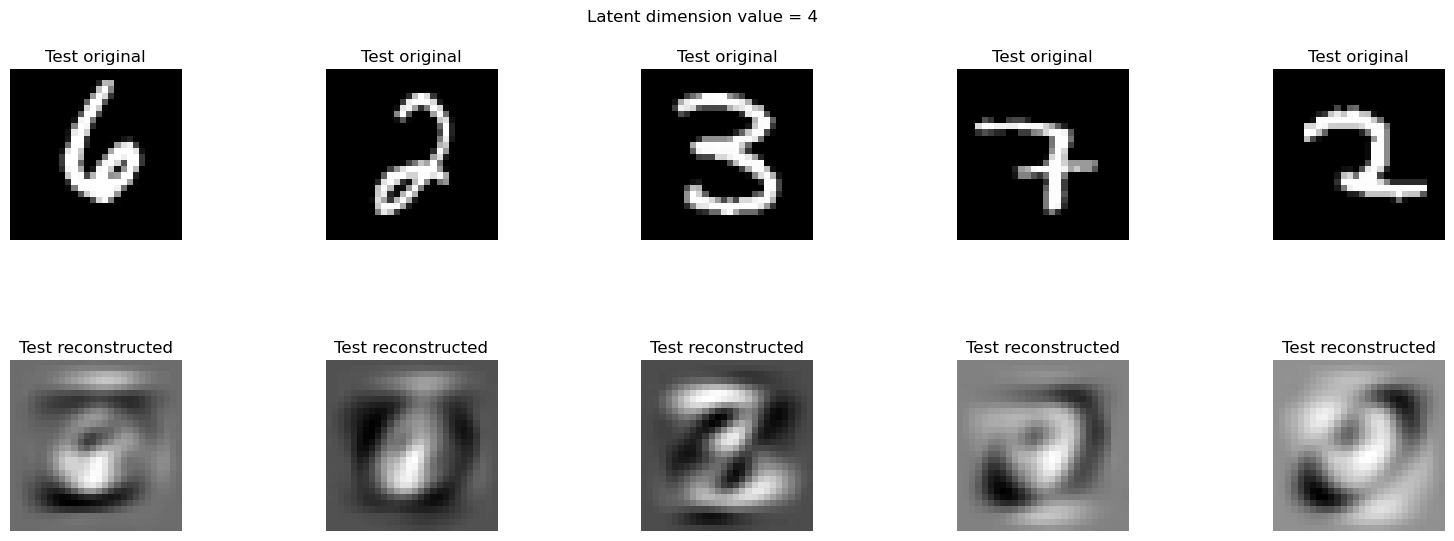

MSE val for latent dimension 8 is 0.1713564360088708


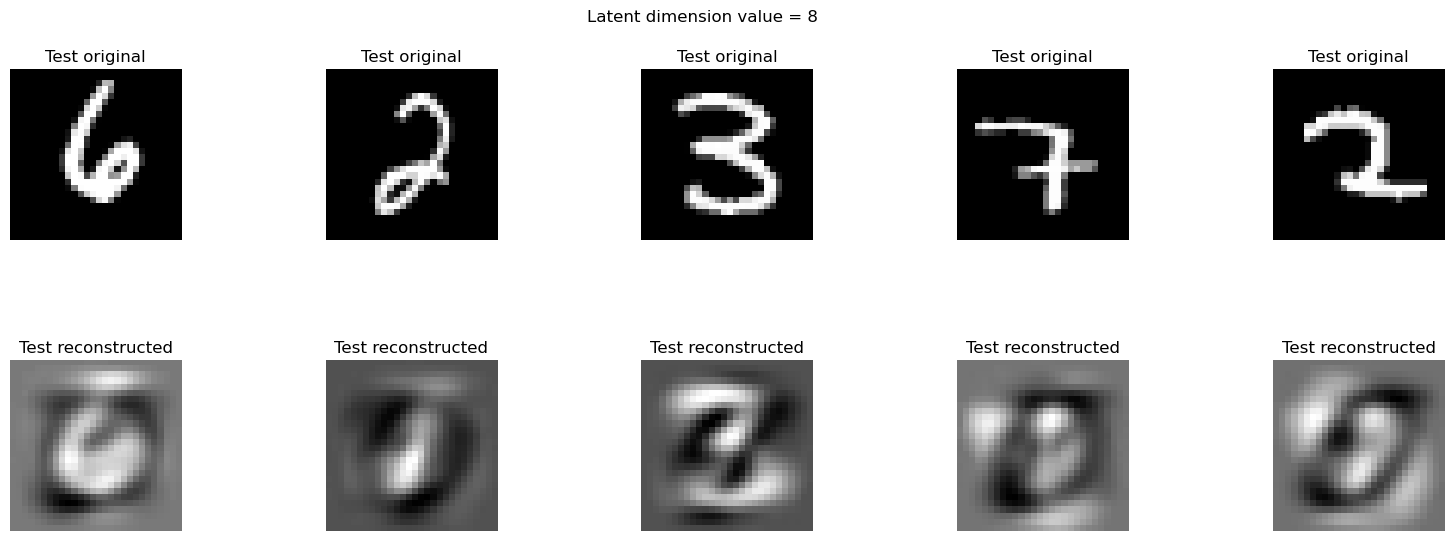

MSE val for latent dimension 16 is 0.22242467271268518


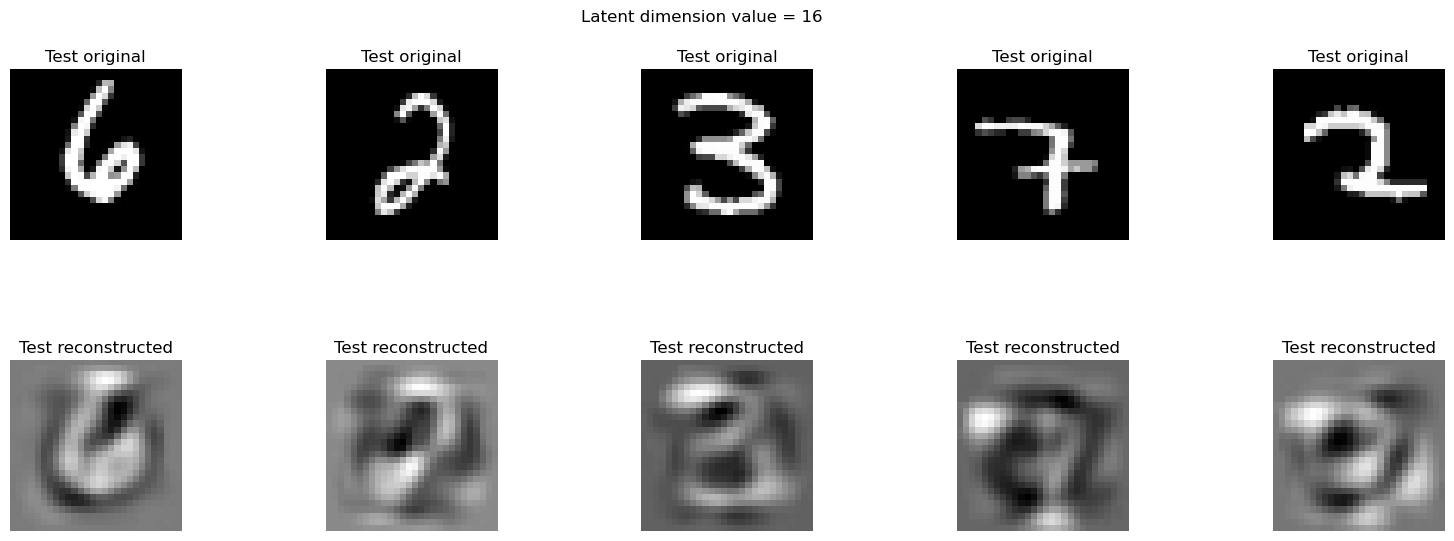

MSE val for latent dimension 32 is 0.2845429060172775


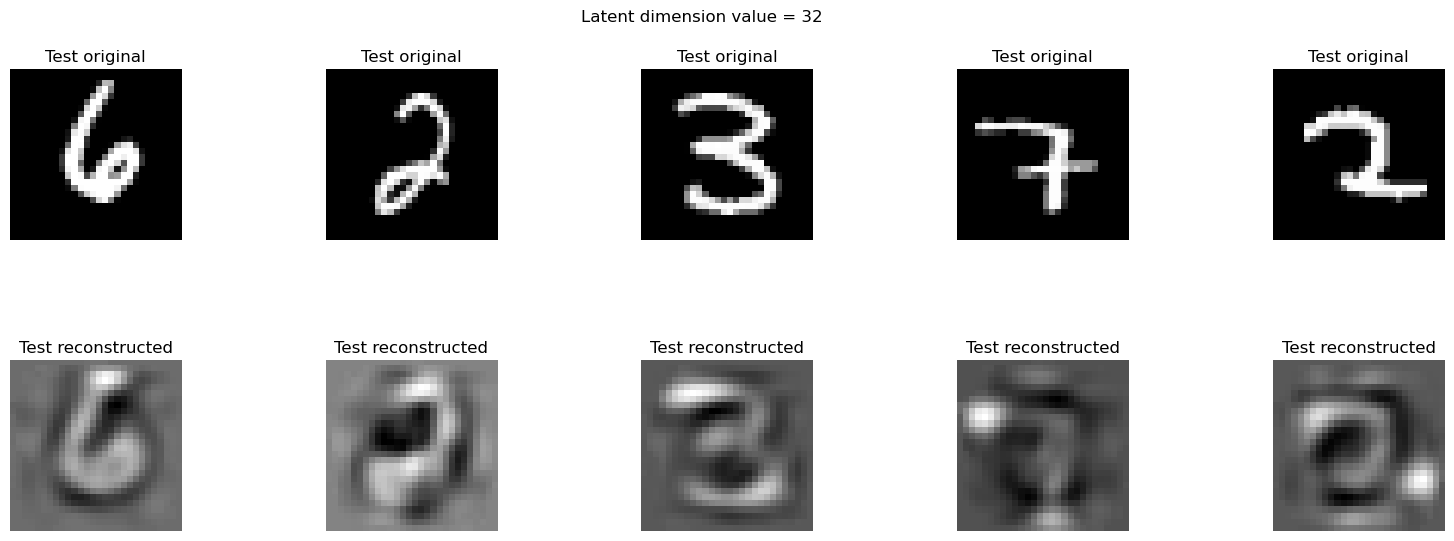

MSE val for latent dimension 64 is 0.36486861253223507


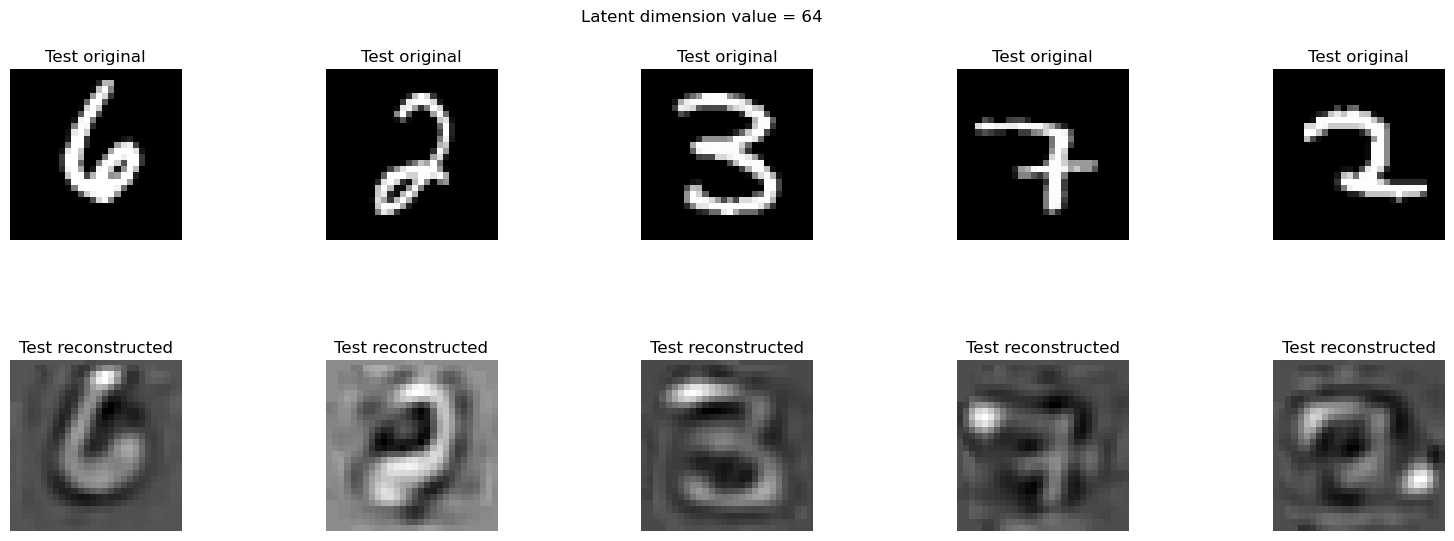

In [14]:
import numpy as np
import matplotlib.pyplot as plt

latentDimensions = [2, 4, 8, 16, 32, 64]

def normalization(flattenedTrainImages):
    mean = np.mean(flattenedTrainImages, axis = 0)
    standardDev = np.std(flattenedTrainImages, axis = 0)

    #Handle 0 variance here, else NaN values are produced
    zeroVarianceIndices = np.where(standardDev == 0)[0]
    standardDev[zeroVarianceIndices] = 1e-5

    normalizedImages = (flattenedTrainImages - mean) / standardDev
    return normalizedImages, mean, standardDev

def probabilisticPCA(normalizedTrainImages, latentDimensionValue):
    numSamples = normalizedTrainImages.shape[0]
    covarianceMatrix = (1/numSamples) * normalizedTrainImages.T @ normalizedTrainImages

    #nan_indices = np.where(np.isnan(covarianceMatrix))
    #print("Indices with NaN in Covariance Matrix:", nan_indices)


    #print("Any NaN in Covariance Matrix:", np.any(np.isnan(covarianceMatrix)))       
    
    eigenValues, eigenVectors = np.linalg.eigh(covarianceMatrix)


    Um = eigenVectors[:, -latentDimensionValue:]    
    Lm = np.diag(eigenValues[-latentDimensionValue:])   #Diagonal matrix of eigenvalues

    I = np.identity(latentDimensionValue)
    sigmaSquare = np.mean(eigenValues[:-latentDimensionValue])
    R = I  # Since its arbitrary, we take R as an identity matrix
    
    weights = Um @ np.sqrt(Lm - sigmaSquare * I) @ R

    return weights


def imageReconstruction(normalizedImages, weights, mean):
    #Z, residuals, _, _ = np.linalg.lstsq(weights.T @ weights + 1e-5 * np.eye(weights.shape[1]), weights.T @ (normalizedImages - mean).T, rcond=None) 
    #print("Weights.T @ Weights:", weights.T @ weights)
    #print("Weights.T @ (normalizedImages - mean).T:", weights.T @ (normalizedImages - mean).T)

    Z = np.linalg.solve((weights.T @ weights), (weights.T) @ (normalizedImages - mean).T) 
    #X = WZ + u
    return (weights @ Z).T + mean

def probabilisticPcaMSE(originalImages, reconstructedImages):
    return np.mean((originalImages - reconstructedImages)**2)



normalizedTrainImages, mean, standardDev = normalization(flattenedTrainImages)

ppca_mse_values_list = []

for latentDimensionValue in latentDimensions:

    normalizedTestImages = (flattenedTestImages - mean) / standardDev
    weights = probabilisticPCA(normalizedTrainImages, latentDimensionValue)
    reconstructedImages = imageReconstruction(normalizedTestImages, weights, mean)
    
    mseVal = probabilisticPcaMSE(flattenedTestImages, reconstructedImages) 
    ppca_mse_values_list.append(mseVal)
    print("MSE val for latent dimension {} is {}".format(latentDimensionValue,mseVal))
    
    plt.figure(figsize=(20,6))
    plt.suptitle(f"Latent dimension value = {latentDimensionValue}")
    #print(reconstructedImages.shape)
    
    for i, idx in enumerate(selectedImages):
        plt.subplot(2, 5, i + 1)
        plt.imshow(testImages[idx], cmap='gray')
        plt.title(f"Test original")
        plt.axis('off') #Removes x and y axis labels

        plt.subplot(2, 5, i + 6)
        plt.imshow(reconstructedImages[idx].reshape(28,28), cmap='gray')    #reshaping the 1d array back to 2d for accessing
        plt.title(f"Test reconstructed")
        plt.axis('off')

    plt.subplots_adjust(hspace=0.7, wspace=0.1)
    plt.show()
ppca_mse_values_array = np.array(ppca_mse_values_list)
    

## VARIATIONAL AUTOENCODER

Epoch 1/10
600/600 [==============================] - 4s 6ms/step - loss: 185.2326 - val_loss: 167.3815
Epoch 2/10
600/600 [==============================] - 3s 5ms/step - loss: 163.4335 - val_loss: 159.9477
Epoch 3/10
600/600 [==============================] - 3s 6ms/step - loss: 156.7015 - val_loss: 154.3511
Epoch 4/10
600/600 [==============================] - 3s 5ms/step - loss: 152.7298 - val_loss: 151.6072
Epoch 5/10
600/600 [==============================] - 3s 6ms/step - loss: 150.2483 - val_loss: 149.6869
Epoch 6/10
600/600 [==============================] - 3s 5ms/step - loss: 148.4781 - val_loss: 147.8594
Epoch 7/10
600/600 [==============================] - 3s 6ms/step - loss: 146.9644 - val_loss: 146.8611
Epoch 8/10
600/600 [==============================] - 4s 6ms/step - loss: 145.6991 - val_loss: 145.9784
Epoch 9/10
600/600 [==============================] - 4s 6ms/step - loss: 144.7519 - val_loss: 145.1916
Epoch 10/10
313/313 [==============================] - 0s 823us/

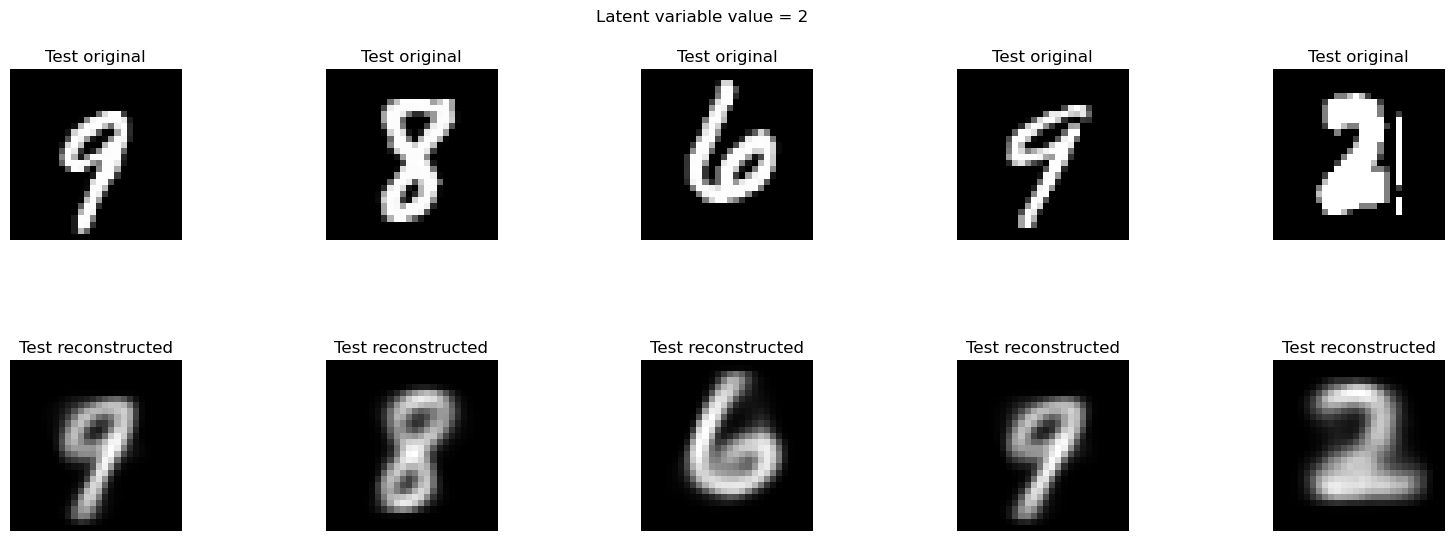

Epoch 1/10
600/600 [==============================] - 4s 6ms/step - loss: 176.3125 - val_loss: 146.0984
Epoch 2/10
600/600 [==============================] - 3s 6ms/step - loss: 139.7631 - val_loss: 134.5103
Epoch 3/10
600/600 [==============================] - 3s 5ms/step - loss: 132.6436 - val_loss: 129.9008
Epoch 4/10
600/600 [==============================] - 4s 6ms/step - loss: 129.0422 - val_loss: 127.8531
Epoch 5/10
600/600 [==============================] - 4s 6ms/step - loss: 126.6759 - val_loss: 125.9410
Epoch 6/10
600/600 [==============================] - 4s 6ms/step - loss: 124.9734 - val_loss: 124.6290
Epoch 7/10
600/600 [==============================] - 4s 6ms/step - loss: 123.5793 - val_loss: 123.3531
Epoch 8/10
600/600 [==============================] - 4s 6ms/step - loss: 122.4382 - val_loss: 122.3818
Epoch 9/10
600/600 [==============================] - 4s 6ms/step - loss: 121.5471 - val_loss: 121.6410
Epoch 10/10
313/313 [==============================] - 0s 617us/

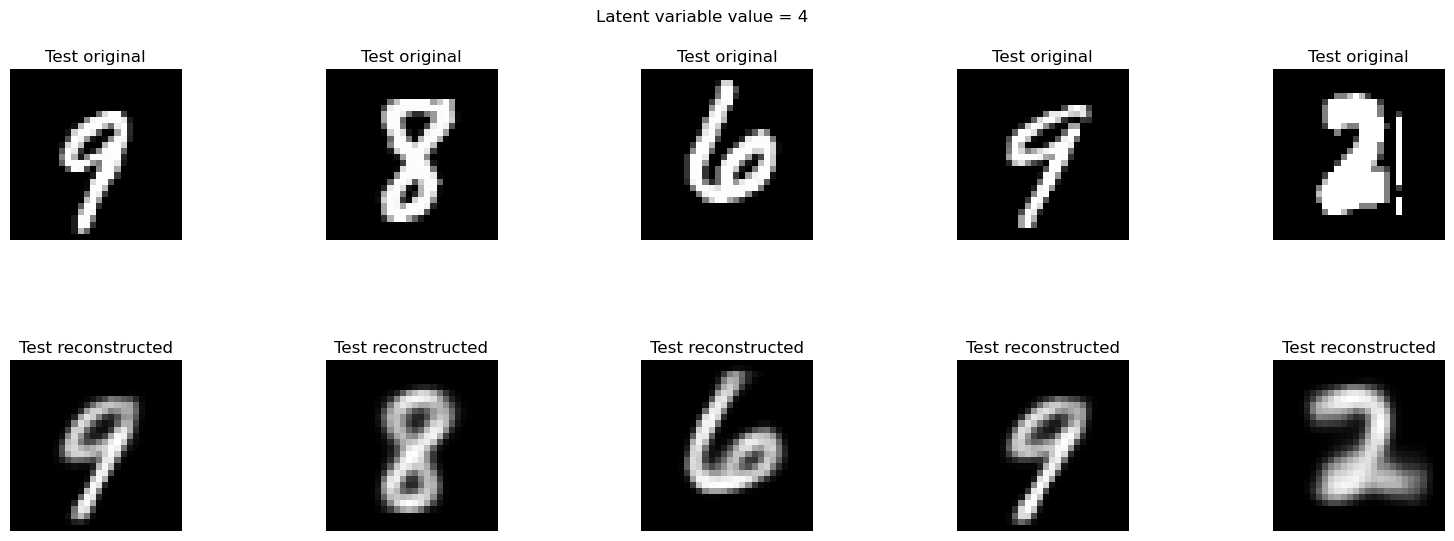

Epoch 1/10
600/600 [==============================] - 3s 5ms/step - loss: 164.2879 - val_loss: 133.7365
Epoch 2/10
600/600 [==============================] - 3s 5ms/step - loss: 125.0374 - val_loss: 118.0554
Epoch 3/10
600/600 [==============================] - 3s 6ms/step - loss: 116.3073 - val_loss: 111.9405
Epoch 4/10
600/600 [==============================] - 3s 6ms/step - loss: 112.2842 - val_loss: 112.0478
Epoch 5/10
600/600 [==============================] - 3s 6ms/step - loss: 109.5802 - val_loss: 107.0387
Epoch 6/10
600/600 [==============================] - 3s 5ms/step - loss: 107.6597 - val_loss: 106.4318
Epoch 7/10
600/600 [==============================] - 3s 5ms/step - loss: 106.1347 - val_loss: 104.9419
Epoch 8/10
600/600 [==============================] - 3s 6ms/step - loss: 104.9875 - val_loss: 103.9720
Epoch 9/10
600/600 [==============================] - 3s 5ms/step - loss: 104.0158 - val_loss: 103.1575
Epoch 10/10
313/313 [==============================] - 0s 759us/

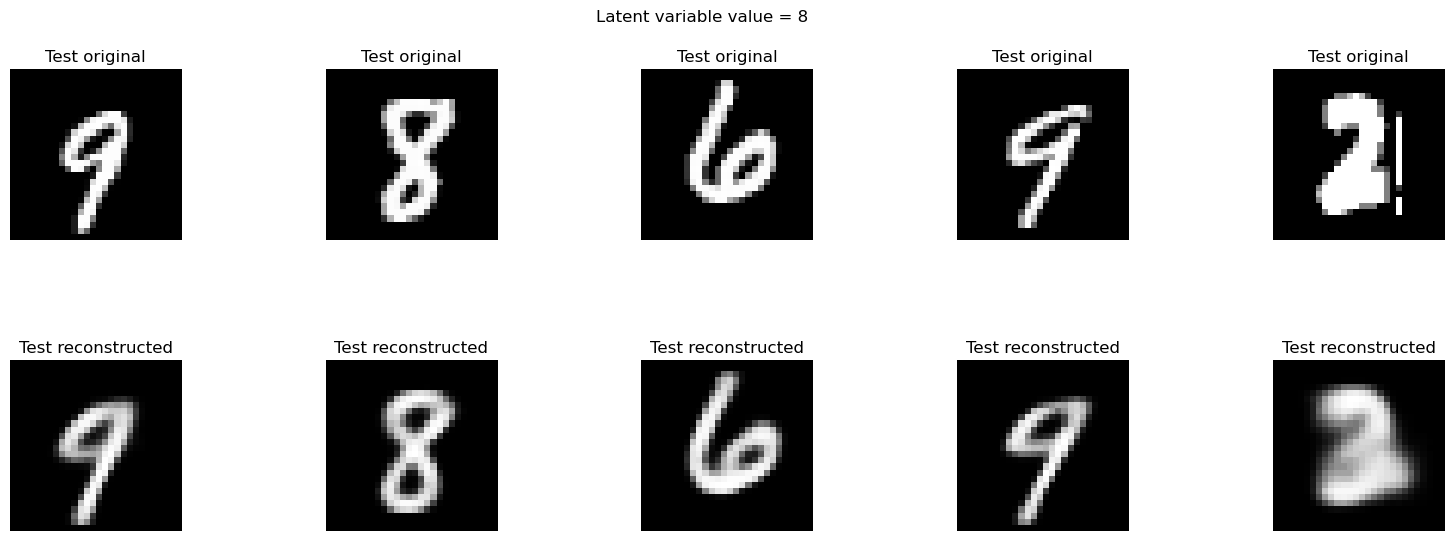

Epoch 1/10
600/600 [==============================] - 4s 6ms/step - loss: 164.4027 - val_loss: 132.1759
Epoch 2/10
600/600 [==============================] - 3s 6ms/step - loss: 123.6320 - val_loss: 116.9299
Epoch 3/10
600/600 [==============================] - 3s 6ms/step - loss: 112.9530 - val_loss: 107.5522
Epoch 4/10
600/600 [==============================] - 3s 6ms/step - loss: 107.3953 - val_loss: 103.8028
Epoch 5/10
600/600 [==============================] - 3s 6ms/step - loss: 103.7923 - val_loss: 102.7676
Epoch 6/10
600/600 [==============================] - 3s 6ms/step - loss: 101.3688 - val_loss: 99.9990
Epoch 7/10
600/600 [==============================] - 3s 6ms/step - loss: 99.6028 - val_loss: 97.1762
Epoch 8/10
600/600 [==============================] - 3s 6ms/step - loss: 98.2384 - val_loss: 97.6312
Epoch 9/10
600/600 [==============================] - 3s 5ms/step - loss: 97.2147 - val_loss: 96.9239
Epoch 10/10
313/313 [==============================] - 0s 708us/step
MS

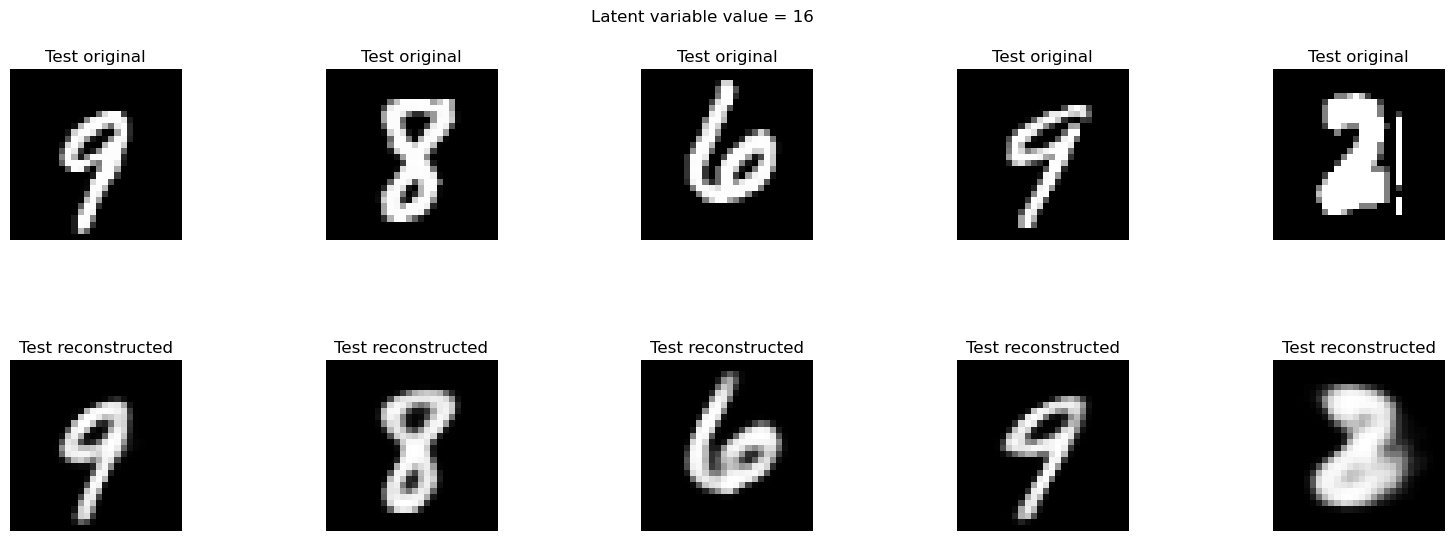

Epoch 1/10
600/600 [==============================] - 3s 5ms/step - loss: 164.8033 - val_loss: 133.1115
Epoch 2/10
600/600 [==============================] - 3s 5ms/step - loss: 126.6935 - val_loss: 118.1325
Epoch 3/10
600/600 [==============================] - 3s 5ms/step - loss: 115.0517 - val_loss: 111.4030
Epoch 4/10
600/600 [==============================] - 3s 6ms/step - loss: 108.5051 - val_loss: 104.4911
Epoch 5/10
600/600 [==============================] - 3s 5ms/step - loss: 104.2542 - val_loss: 101.0467
Epoch 6/10
600/600 [==============================] - 3s 5ms/step - loss: 101.3586 - val_loss: 99.1541
Epoch 7/10
600/600 [==============================] - 3s 5ms/step - loss: 99.4335 - val_loss: 97.9516
Epoch 8/10
600/600 [==============================] - 3s 5ms/step - loss: 97.9889 - val_loss: 97.3231
Epoch 9/10
600/600 [==============================] - 3s 5ms/step - loss: 97.0338 - val_loss: 96.9883
Epoch 10/10
313/313 [==============================] - 0s 587us/step
MS

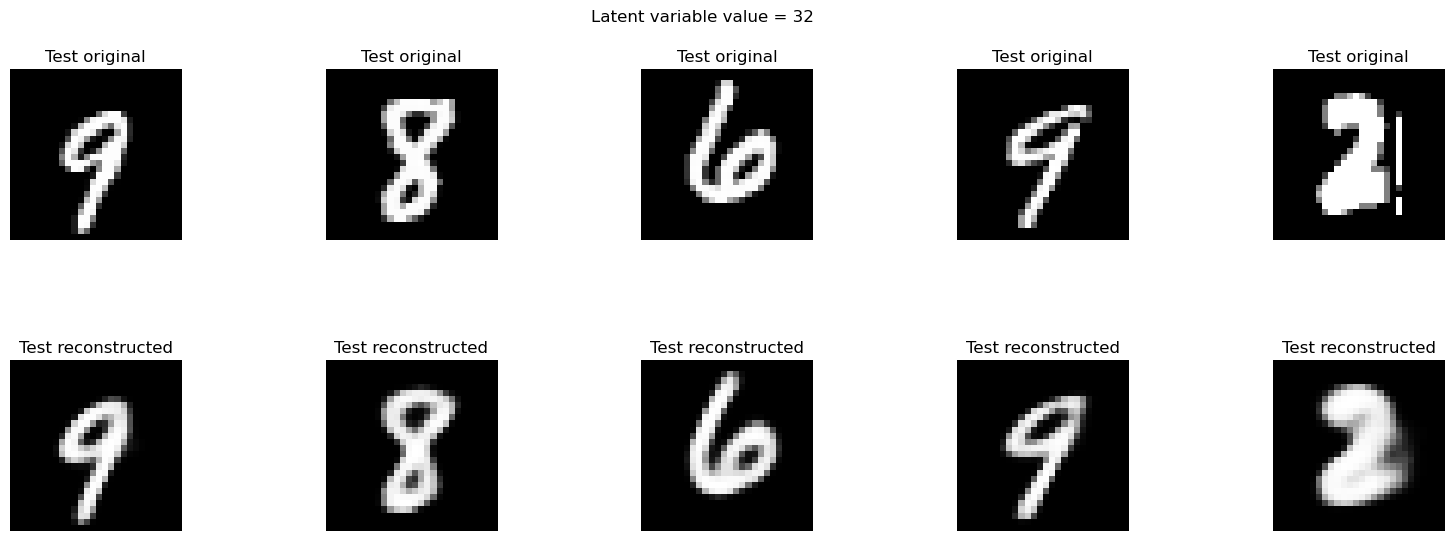

Epoch 1/10
600/600 [==============================] - 4s 5ms/step - loss: 167.2687 - val_loss: 137.9765
Epoch 2/10
600/600 [==============================] - 3s 5ms/step - loss: 130.3850 - val_loss: 123.6483
Epoch 3/10
600/600 [==============================] - 3s 5ms/step - loss: 117.9095 - val_loss: 112.8853
Epoch 4/10
600/600 [==============================] - 3s 5ms/step - loss: 110.9980 - val_loss: 107.4893
Epoch 5/10
600/600 [==============================] - 3s 5ms/step - loss: 106.3714 - val_loss: 104.7169
Epoch 6/10
600/600 [==============================] - 3s 5ms/step - loss: 103.3953 - val_loss: 103.7699
Epoch 7/10
600/600 [==============================] - 3s 5ms/step - loss: 101.1770 - val_loss: 100.5369
Epoch 8/10
600/600 [==============================] - 3s 5ms/step - loss: 99.3733 - val_loss: 97.9935
Epoch 9/10
600/600 [==============================] - 3s 5ms/step - loss: 97.9509 - val_loss: 98.8787
Epoch 10/10
313/313 [==============================] - 0s 762us/step

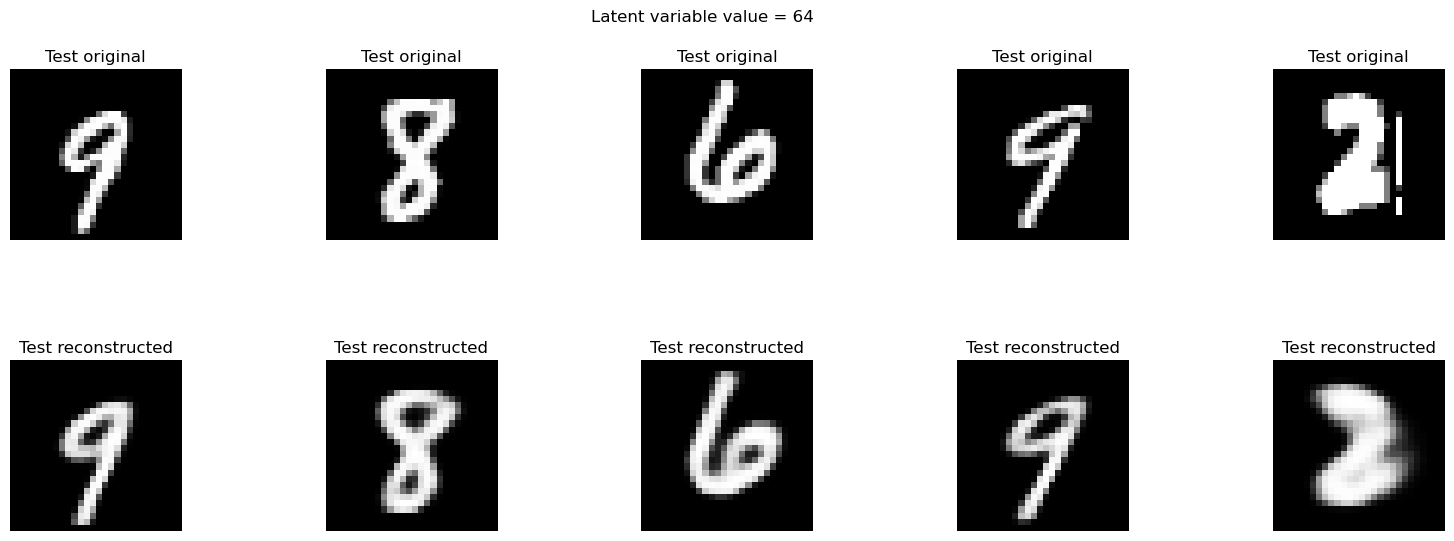

In [15]:
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from keras.datasets import mnist
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from scipy.stats import norm

latentDimensions = [2, 4, 8, 16, 32, 64]
# latentDimensions = [2]
randomImages = random.sample(range(len(testImages)), 5)

batch_size, epoch = 100, 10
n_hidden = 256

def normalization(flattenedTrainImages):
    mean = np.mean(flattenedTrainImages, axis = 0)
    standardDev = np.std(flattenedTrainImages, axis = 0)

    #Handle 0 variance here, else NaN values are produced
    zeroVarianceIndices = np.where(standardDev == 0)[0]
    standardDev[zeroVarianceIndices] = 1e-5

    normalizedImages = (flattenedTrainImages - mean) / standardDev
    return normalizedImages, mean, standardDev

def variationalAutoEncoder(flattenedTrainImages, flattenedTestImages, latentDimensionValue):
    
    x = Input(shape=(flattenedTrainImages.shape[1:]))
    h1 = Dense(256, activation='relu')(x)
    h1 = Dense(128, activation='relu')(h1)

    mu = Dense(latentDimensionValue)(h1)
    log_var = Dense(latentDimensionValue)(h1)

    def sampling(args):
        mu, log_var = args
        eps = K.random_normal(shape=(batch_size, latentDimensionValue), mean=0., stddev=1.0)
        return mu + K.exp(log_var) * eps

    z = Lambda(sampling, output_shape=(latentDimensionValue,))([mu, log_var])

    z1 = Dense(128, activation='relu')
    z2 = Dense(256, activation='relu')
    y_decoder = Dense(flattenedTrainImages.shape[1], activation='sigmoid')

    h2 = z1(z)
    h2 = z2(h2)
    y = y_decoder(h2)

    kl_loss = 0.5 * K.sum(K.square(mu) + K.exp(log_var) - log_var - 1, axis = -1)
    reconstruction_loss = K.sum(K.binary_crossentropy(x, y), axis=-1)

    vae_loss = reconstruction_loss + kl_loss

    vae = Model(x, y)
    vae.add_loss(vae_loss)
    vae.compile(optimizer='rmsprop')

    vae.fit(flattenedTrainImages,epochs=epoch,batch_size=batch_size,validation_data=(flattenedTestImages, None), verbose=1)

    encoder = Model(x, mu)
    z_latent = encoder.predict(flattenedTestImages, batch_size=batch_size)

    decoder_input = Input(shape=(latentDimensionValue,))
    h3 = z1(decoder_input)
    h3 = z2(h3)
    generatedImage = y_decoder(h3)
    generator = Model(decoder_input, generatedImage)

    reconstructed = generator.predict(z_latent)
    
    return reconstructed


normalizedTrainImages, mean, standardDev = normalization(flattenedTrainImages)
VAE_mse_values_list = []
for latentDimensionValue in latentDimensions:

    normalizedTestImages = (flattenedTestImages - mean) / standardDev
    reconstructedImages = variationalAutoEncoder(flattenedTrainImages, flattenedTestImages, latentDimensionValue)
    mseVal = np.mean(np.square(flattenedTestImages - reconstructedImages))
    VAE_mse_values_list.append(mseVal)
    print("MSE for latent dimension {} is: {}".format(latentDimensionValue,mseVal))

    plt.figure(figsize=(20,6))
    plt.suptitle(f"Latent variable value = {latentDimensionValue}")

    for i, idx in enumerate(randomImages):
        plt.subplot(2, 5, i + 1)
        plt.imshow(testImages[idx], cmap='gray')
        plt.title(f"Test original")
        plt.axis('off') #Removes x and y axis labels

        plt.subplot(2, 5, i + 6)
        # reconstructed_image_np = reconstructedImages[idx].numpy()
        plt.imshow(reconstructedImages[idx].reshape(28,28), cmap='gray')
        plt.title(f"Test reconstructed")
        plt.axis('off')

    plt.subplots_adjust(hspace=0.7, wspace=0.1)
    plt.show()
VAE_mse_values_array = np.array(VAE_mse_values_list)

## GRAPH PLOTTING

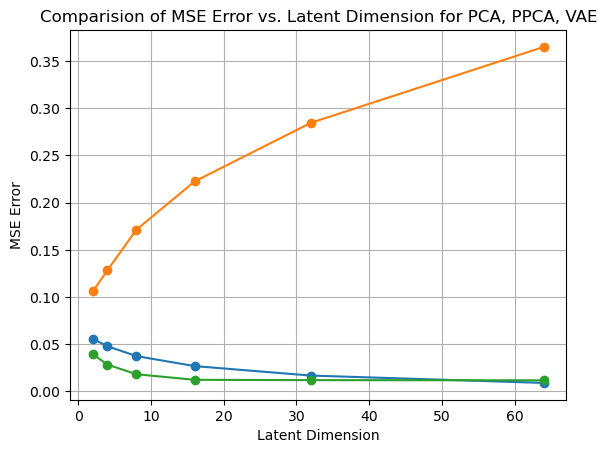

In [19]:
import numpy as np
import matplotlib.pyplot as plt

latent_dimensions = [2, 4, 8, 16, 32, 64]

# Plotting
plt.plot(latent_dimensions, mse_values_array, marker='o')
plt.plot(latent_dimensions, ppca_mse_values_array, marker='o')
plt.plot(latent_dimensions, VAE_mse_values_array, marker='o')
plt.xlabel('Latent Dimension')
plt.ylabel('MSE Error')
plt.title('Comparision of MSE Error vs. Latent Dimension for PCA, PPCA, VAE')
plt.grid(True)
plt.show()